## Installations

Weights & Biases (WandB) is a machine learning development platform that allows users to track and visualize various aspects of their model training process in real-time.<br>
Link: https://wandb.ai/site

In order to use this helpful platform, first, you need to sign up in the website with the provided link. <br>
During the training you need to use your key-code to connect and see your online training results. <br>

!pip install wandb

Ultralytics provides cutting-edge solutions for a wide range of AI tasks, including detection, segmentation, classification, tracking and pose estimation.<br>
For this specific project, I employed the YOLO8 model developed by Ultralytics. <br>
This model stands as the pinnacle of YOLO models, showcasing unparalleled performance and raising the bar in real-time detection and segmentation.<br>
Link (website): https://ultralytics.com/
Link (GitHub) : https://github.com/ultralytics

!pip install ultralytics

This version of numpy is required

!pip install numpy==1.23.4

## import libraries

In [8]:
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from ultralytics import YOLO
import wandb
import shutil
from shutil import copytree, ignore_patterns
import os
import numpy as np

## Functions

In [9]:
def convert_xml_to_txt(label_path,xml_file,class_dict,destination_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    x=root.find('filename').text
    txt_file = x.replace('.jpg','.txt')
    txt_file = os.path.join(destination_file,txt_file)
    with open(txt_file,'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in class_dict:
                continue
            class_id = class_dict[class_name]
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            xmax = int(bbox.find('xmax').text)
            ymin = int(bbox.find('ymin').text)
            ymax = int(bbox.find('ymax').text)
            
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)
            
            x_center = (xmin + xmax) / 2 / image_width if image_width != 0 else (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2 / image_height if image_height != 0 else (ymin + ymax) / 2
            width = (xmax - xmin) / image_width if image_width != 0 else (xmax - xmin)
            height = (ymax - ymin) / image_height if image_height != 0 else (ymax - ymin)
             
            line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            f.write(line)

## Dataset 1 (Fruits): Pre-processing

__Hint:__ If the datasets are zipped, unzip those before running below cells <br>
    
This is a small dataset of fruits including the ground truth for the class of fruits of: <br>
Apple: 0 <br>
Banana: 1<br>
Orange: 2<br>
and, the box around each, _x1,x2,y1,and y2_.

In [10]:
   """ Root path for the dataset 1 """
root_path = './datasets/dataset_fruits/'
os.listdir(root_path)

['test', 'test_zip', 'train', 'train_zip']

In [19]:
   """ Paths to the train & test data """
    
train_data_path = os.path.join(root_path,'train_zip/train')
test_data_path = os.path.join(root_path,'test_zip/test')

In [20]:
   """All .xml and .jpg file names"""
    
train_data_description = os.listdir(train_data_path)
test_data_description = os.listdir(test_data_path)

In [21]:
 """train_annotaion_file_paths and test_annotation_file_paths contains all .xml file paths
   train_image_file_paths and test_image_file_paths contains all .jpg file paths"""
    
train_annotation_file_paths = [os.path.join(train_data_path,i) for i in train_data_description if '.xml' in i]
train_image_file_paths = [os.path.join(train_data_path,i) for i in train_data_description if '.jpg' in i]

test_annotation_file_paths = [os.path.join(test_data_path,i) for i in test_data_description if '.xml' in i]
test_image_file_paths = [os.path.join(test_data_path,i) for i in test_data_description if '.jpg' in i]

print(f'length of training Data {len(train_image_file_paths)}, length of test data {len(test_image_file_paths)}')

length of training Data 240, length of test data 60


In [23]:
"""Creating required directories to labels"""
    
for i in ['train/labels','test/labels']:
    directory_name = os.path.join('./datasets/dataset_fruits/',i)
    if os.path.exists(directory_name):
        shutil.rmtree(directory_name)
    os.makedirs(directory_name)
    
"""Copying all images to required directories"""
copytree(train_data_path,'./datasets/dataset_fruits/train/images/',ignore = ignore_patterns('*.xml'))
copytree(test_data_path,'./datasets/dataset_fruits/test/images/',ignore = ignore_patterns('*.xml'))

'./datasets/dataset_fruits/test/images/'

In [24]:
class_dict = {'apple':0,'banana':1,'orange':2}
dest_path = './datasets/dataset_fruits/train/labels/'
for i in train_annotation_file_paths:
    convert_xml_to_txt(train_data_path,i,class_dict,dest_path)
dest_path = './datasets/dataset_fruits/test/labels/'
for i in test_annotation_file_paths:
    convert_xml_to_txt(test_data_path,i,class_dict,dest_path)

## Training the pre-trained version of YOLO8 on Dataset 1

In [25]:
 """yaml file path, you can check the file"""
yaml_path = "./data_FRUITS.yaml"

In [26]:
model = YOLO('yolov8n.pt')

In [ ]:
'''Training model'''
results = model.train(data=yaml_path, epochs=500, batch=4)

## Results and visualizations

In [28]:
'''Load the model'''
model = YOLO('./train1/weights/best.pt')
img_dict = {0:'apple',1:'banana',2:'orange'}


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_fruits\test_zip\test\apple_87.jpg: 640x640 1 apple, 100.8ms
Speed: 6.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


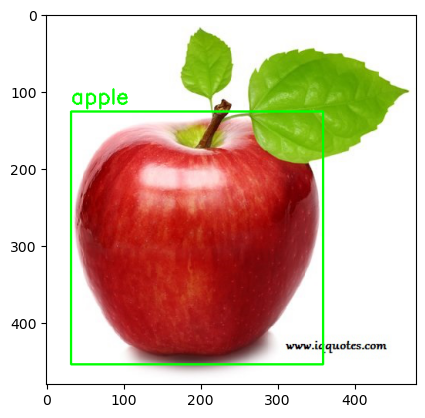

In [29]:
'''Load the images from each type of apples, bananas, oranges, and mixed fruits'''
path_img = './datasets/dataset_fruits/test_zip/test/apple_87.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
colors = ['r','y','b']
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_fruits\test_zip\test\banana_89.jpg: 640x640 3 bananas, 64.8ms
Speed: 4.0ms preprocess, 64.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


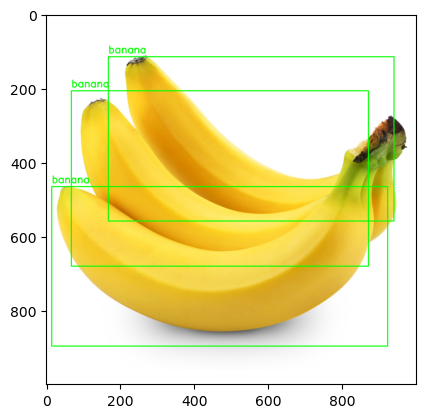

In [30]:
path_img = './datasets/dataset_fruits/test_zip/test/banana_89.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_fruits\test_zip\test\orange_81.jpg: 512x640 3 oranges, 63.8ms
Speed: 3.0ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


92.06884765625 0.9130624532699585 2.0
579.6477661132812 0.8201635479927063 2.0
320.4881591796875 0.7692663669586182 2.0


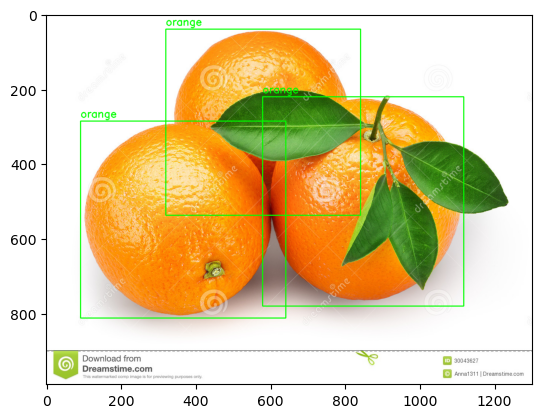

In [31]:
path_img = './datasets/dataset_fruits/test_zip/test/orange_81.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        print(x1,confidence,label)
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_fruits\test_zip\test\mixed_22.jpg: 640x640 1 apple, 2 bananas, 1 orange, 103.3ms
Speed: 0.0ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


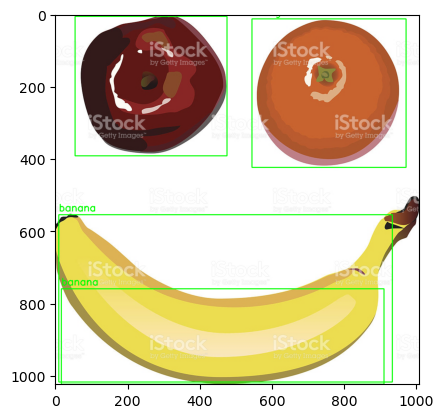

In [32]:
path_img = './datasets/dataset_fruits/test_zip/test/mixed_22.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)

## Dataset 2 (VOC): Pre-processing

__Hint:__ If the datasets are zipped, unzip those before running below cells

This is a huge dataset of indoor and outdoor images including the ground truth for 20 different classes of: <br>
  0: aeroplane<br>
  1: bicycle<br>
  2: boat<br>
  3: bus<br>
  4: car<br>
  5: motorbike<br>
  6: train<br>
  7: bird<br>
  8: cat<br>
  9: cow<br>
  10: dog<br>
  11: horse<br>
  12: sheep<br>
  13: person<br>
  14: bottle<br>
  15: chair<br>
  16: dining table<br>
  17: potted plant<br>
  18: sofa<br>
  19: tv/monitor<br>
and, the box around each, _x1,x2,y1,and y2_.


In [33]:
   """ Root path for the dataset 1 """
root_path = './datasets/dataset_VOC/'
os.listdir(root_path)

['test_zip', 'train_zip']

In [34]:
   """ Paths to the train & test data """
    
train_data_path = os.path.join(root_path,'train_zip/train')
test_data_path = os.path.join(root_path,'test_zip/test')

In [35]:
   """All .xml and .jpg file names"""
    
train_data_description = os.listdir(train_data_path)
test_data_description = os.listdir(test_data_path)

In [36]:
 """train_annotaion_file_paths and test_annotation_file_paths contains all .xml file paths
   train_image_file_paths and test_image_file_paths contains all .jpg file paths"""
    
train_annotation_file_paths = [os.path.join(train_data_path,i) for i in train_data_description if '.xml' in i]
train_image_file_paths = [os.path.join(train_data_path,i) for i in train_data_description if '.jpg' in i]

test_annotation_file_paths = [os.path.join(test_data_path,i) for i in test_data_description if '.xml' in i]
test_image_file_paths = [os.path.join(test_data_path,i) for i in test_data_description if '.jpg' in i]

print(f'length of training Data {len(train_image_file_paths)}, length of test data {len(test_image_file_paths)}')

length of training Data 775, length of test data 514


In [37]:
"""Creating required directories to labels"""
    
for i in ['train/labels','test/labels']:
    directory_name = os.path.join('./datasets/dataset_VOC/',i)
    if os.path.exists(directory_name):
        shutil.rmtree(directory_name)
    os.makedirs(directory_name)
    
"""Copying all images to required directories"""
copytree(train_data_path,'./datasets/dataset_VOC/train/images/',ignore = ignore_patterns('*.xml'))
copytree(test_data_path,'./datasets/dataset_VOC/test/images/',ignore = ignore_patterns('*.xml'))

'./datasets/dataset_VOC/test/images/'

In [38]:
class_dict = {'aeroplane':0, 'bicycle':1, 'boat':2, 'bus':3, 
              'car':4, 'motorbike':5, 'train':6, 'bird':7, 
              'cat':8, 'cow':9, 'dog':10, 'horse':11, 'sheep':12,'person':13,
             'bottle':14, 'chair':15, 'dining table':16, 'potted plant':17, 'sofa':18, 'tv/monitor':19}

dest_path = './datasets/dataset_VOC/train/labels/'
for i in train_annotation_file_paths:
    convert_xml_to_txt(train_data_path,i,class_dict,dest_path)
dest_path = './datasets/dataset_VOC/test/labels/'
for i in test_annotation_file_paths:
    convert_xml_to_txt(test_data_path,i,class_dict,dest_path)

## Training the pre-trained version of YOLO8 on Dataset 2

In [39]:
 """yaml file path, you can check the file"""
yaml_path = "./data_VOC.yaml"

In [40]:
model = YOLO('yolov8n.pt')

In [ ]:
'''Training model'''
results = model.train(data=yaml_path, epochs=500, batch=4)

## Results and visualizations

In [42]:
'''Load the model'''
model = YOLO('./train2/weights/best.pt')
img_dict = {  0: 'aeroplane',  1: 'bicycle',  2: 'boat',  3: 'bus',  4: 'car',  5: 'motorbike',  6: 'train',  
            7: 'bird',  8: 'cat',  9: 'cow',  10:'dog' , 11:'horse',  12:'sheep',  13:'person',  14:'bottle',  15:'chair',  16:'dining table',
            17:'potted plant',  18:'sofa',  19:'tv/monitor'}


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_VOC\test_zip\test\000004.jpg: 544x640 8 cars, 81.4ms
Speed: 18.3ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


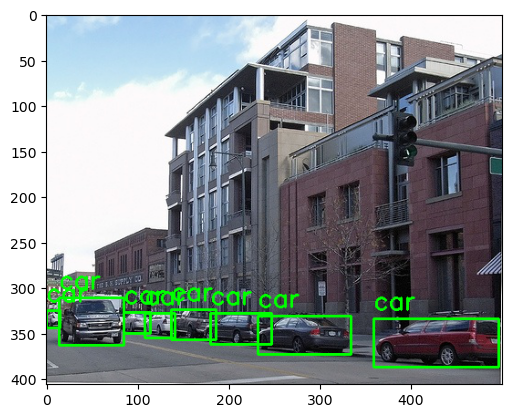

In [43]:
'''Load the images from each type of apples, bananas, oranges, and mixed fruits'''
path_img = './datasets/dataset_VOC/test_zip/test/000004.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
colors = ['r','y','b']
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_VOC\test_zip\test\000069.jpg: 480x640 2 boats, 1 person, 75.4ms
Speed: 0.0ms preprocess, 75.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


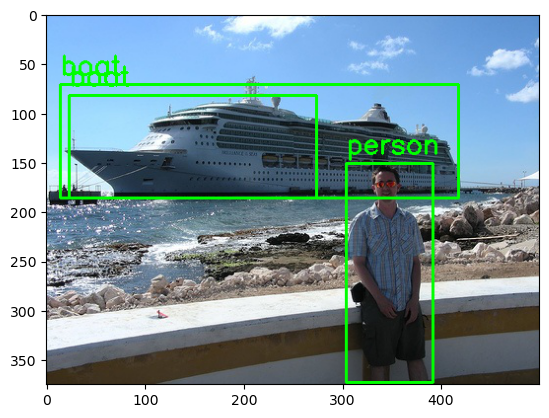

In [44]:
'''Load the images from each type of apples, bananas, oranges, and mixed fruits'''
path_img = './datasets/dataset_VOC/test_zip/test/000069.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
colors = ['r','y','b']
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_VOC\test_zip\test\000185.jpg: 640x576 2 boats, 1 person, 1 chair, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


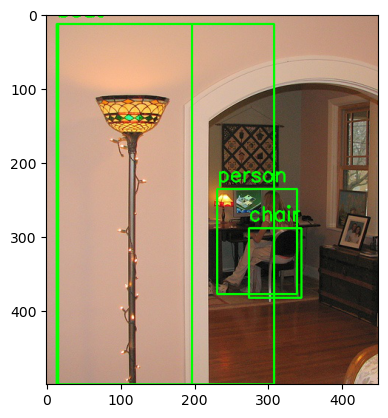

In [45]:
'''Load the images from each type of apples, bananas, oranges, and mixed fruits'''
path_img = './datasets/dataset_VOC/test_zip/test/000185.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
colors = ['r','y','b']
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)


image 1/1 C:\Users\arminabd\Desktop\github\object_detection_localization_YOLO\datasets\dataset_VOC\test_zip\test\000297.jpg: 608x640 1 horse, 1 person, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


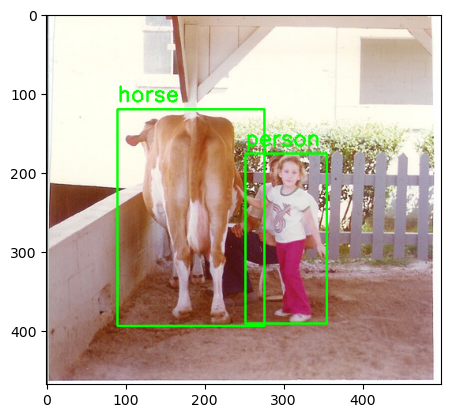

In [46]:
'''Load the images from each type of apples, bananas, oranges, and mixed fruits'''
path_img = './datasets/dataset_VOC/test_zip/test/000297.jpg'
image = np.array(Image.open(path_img))
image_results = model(path_img)
confi_lvl_cut = 0.2
colors = ['r','y','b']
for bbox in image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox
    if confidence>=confi_lvl_cut:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
plt.imshow(image)